## Imports and Installations

To tackle this assignement we need to install the **transformers** and **dataset** packages provided by Huggingface and the **allennlp_models** to take advantage of their SQUADf1 implementation

In [1]:
!pip install allennlp_models
!pip install transformers
!pip install datasets
import datasets
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.utils import set_random_seed
import sklearn as sk
from sklearn.model_selection import GroupShuffleSplit
from transformers import TFEncoderDecoderModel, AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from tqdm.notebook import tqdm
import absl.logging
from allennlp_models.rc.tools import squad
absl.logging.set_verbosity(absl.logging.ERROR)
matplotlib.rcParams['figure.figsize'] = [8, 8]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We'll now set a seed for results reproducibility

In [2]:
def set_seed(seed):
  np.random.seed(seed)
  set_random_seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

seeds = [42, 2022, 1337]
set_seed(seeds[0])

### Dataset download

In [3]:
#Code provided in assignment docs
#Dataset download
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [4]:
# Train and test data loading
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')

### Reading data from JSON

In [5]:
def from_json(path, columns):
    df = pd.read_json(path)
    del df["version"]
    row_array = []

    for i, row in df.iterrows():
        for index in range(len(row["data"]["questions"])):
            row_insert = []
            row_insert.append(row["data"]["source"])
            row_insert.append(row["data"]["id"])
            row_insert.append(row["data"]["filename"])
            row_insert.append(row["data"]["story"])
            row_insert.append(row["data"]["questions"][index]["input_text"])
            row_insert.append(row["data"]["questions"][index]["turn_id"])
            row_insert.append(row["data"]["answers"][index]["span_start"])
            row_insert.append(row["data"]["answers"][index]["span_end"])
            row_insert.append(row["data"]["answers"][index]["span_text"])
            row_insert.append(row["data"]["answers"][index]["input_text"])
            row_insert.append(row["data"]["answers"][index]["turn_id"])
            row_array.append(row_insert[:len(columns)])

    df = pd.DataFrame(row_array, columns=columns)
    df = df[df["answer"] != "unknown"]  # Removing unanserable questions
    return df

In [6]:
columns_headers = ["source", "id", "filename", "story", "question", "qturn_id", "span_start","span_end", "span_text", "answer", "aturn_id"]
train_val_df = from_json('coqa/train.json', columns_headers)
test_df = from_json('coqa/test.json', columns_headers) 

### Splitting the train set into train and validation

In [7]:
#creating the group splitter to split the dataset with respect to stories
#story cannot be presented in train and validation sets at the same time
group_split = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
split = group_split.split(train_val_df, groups=train_val_df["id"])

train_inds, val_inds = next(split)

train_df = train_val_df.iloc[train_inds]
val_df = train_val_df.iloc[val_inds]

train_df.head()

,source,id,filename,story,question,qturn_id,span_start,span_end,span_text,answer,aturn_id
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,1,151,179,Formally established in 1475,It was formally established in 1475,1
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",what is the library for?,2,454,494,he Vatican Library is a research library,research,2
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",for what subjects?,3,457,511,Vatican Library is a research library for hist...,"history, and law",3
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",and?,4,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,5,769,879,"March 2014, the Vatican Library began an initi...",a project,5


# Dataset Statistics

We'll now extract useful statistics from the dataset.

The first thing I want to check is how the length of the question + the context (our input) is distributed in the training set:

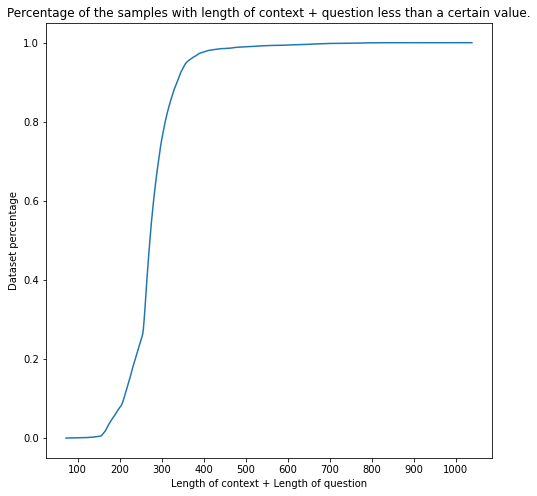

In [8]:
dist = {}
for _, row in train_df.iterrows():
  length = len(row['story'].split()) + len(row['question'].split())
  dist[length] = dist.get(length, 0) + 1

sorted_keys = sorted(dist.keys())
total = sum(dist.values())
dist = {k: sum([dist[i] for i in sorted_keys if i < k])/total for k in sorted_keys}
plt.plot(list(dist.keys()), list(dist.values()))
plt.xticks([i for i in range(100, max(dist.keys()), 100)])
plt.xlabel('Length of context + Length of question')
plt.ylabel('Dataset percentage')
plt.title('Percentage of the samples with length of context + question less than a certain value.');

As we can see, more than 80% of the dataset has an input length less or equal than 400, this will be very useful when defining the input length of our models. In fact, while a longer input means less truncated data, it also means harder computation and more RAM required to run our models.

Let's check how many samples are under 400 length:

In [9]:
dist[400]

0.9765217188665175

Very well most samples are below the 400 threshold. Let's set this value as our input length for now.

In [10]:
input_len = 400

Let's now check the same thing but for the length of the answer

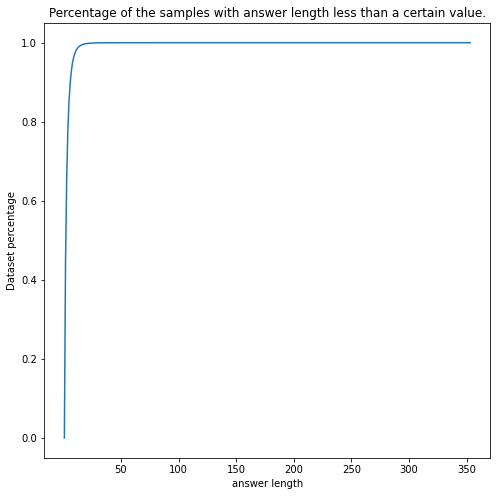

In [11]:
dist = {}
for _, row in train_df.iterrows():
  length = len(row['answer'].split())
  dist[length] = dist.get(length, 0) + 1

sorted_keys = sorted(dist.keys())
total = sum(dist.values())
dist = {k: sum([dist[i] for i in sorted_keys if i < k])/total for k in sorted_keys}
plt.plot(list(dist.keys()), list(dist.values()))
plt.xticks([i for i in range(50, max(dist.keys()), 50)])
plt.xlabel('answer length')
plt.ylabel('Dataset percentage')
plt.title('Percentage of the samples with answer length less than a certain value.');

Basically more than 95% of the dataset has answers shorter than 50 tokens. Let's plot only these values then:

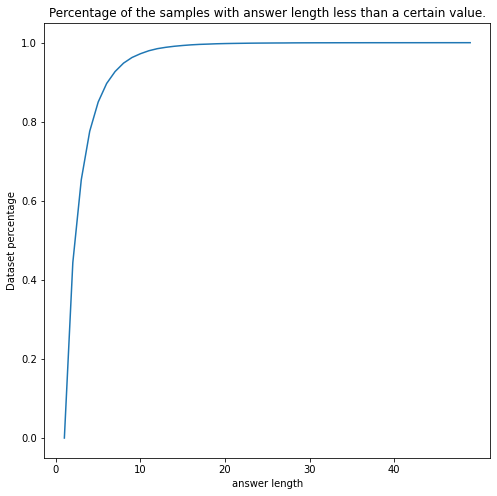

In [12]:
filtered_dist = {k: dist[k] for k in sorted_keys if k < 50}
plt.plot(list(filtered_dist.keys()), list(filtered_dist.values()))
plt.xticks([i for i in range(0, max(filtered_dist.keys()), 10)])
plt.xlabel('answer length')
plt.ylabel('Dataset percentage')
plt.title('Percentage of the samples with answer length less than a certain value.');

Even 10 seems to cover almost the totality of the dataset, let's see:

In [13]:
dist[10]

0.9720008389261745

10 covers 97% of the answers of the dataset. We are going to use 10 as our output length

In [14]:
out_len = 10

Lastly we'll convert our dataframes to huggingface datasets.

In [15]:
ds_train = datasets.Dataset.from_pandas(train_df)
ds_train = ds_train.remove_columns(set(ds_train.column_names)-set(['story', 'question', 'answer', 'span_start', 'span_end']))
ds_val = datasets.Dataset.from_pandas(val_df)
ds_val = ds_val.remove_columns(set(ds_val.column_names)-set(['story', 'question', 'answer', 'span_start', 'span_end']))
ds_test = datasets.Dataset.from_pandas(test_df)
ds_test = ds_test.remove_columns(set(ds_test.column_names)-set(['story', 'question', 'answer', 'span_start', 'span_end']))

### Question answering - bert_generation approach

In [ ]:
class GenModel(tf.keras.Model):

  def __init__(self, model_name, input_len, output_len, **kwargs):
      super(GenModel, self).__init__(**kwargs)
      self.model_name = model_name
      self.input_len = input_len
      self.output_len = output_len
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
      self.model = TFEncoderDecoderModel.from_encoder_decoder_pretrained(self.model_name, 
                                                                         self.model_name,
                                                                         encoder_from_pt=True,
                                                                         decoder_from_pt=True,
                                                                         tie_encoder_decoder=True)
      self.model.config.decoder_start_token_id = self.tokenizer.cls_token_id
      self.model.config_eos_token_id = self.tokenizer.sep_token_id
      self.model.config.pad_token_id = self.tokenizer.pad_token_id
      self.model.config.vocab_size = self.model.config.encoder.vocab_size

  def call(self, inputs, **kwargs):
      loss = self.model(input_ids=inputs['input_ids'],
                        attention_mask=inputs['input_attention_mask'],
                        labels=inputs['labels'], training=True).loss
      return loss

  def generate(self, **kwargs):
      return self.model.generate(decoder_start_token_id=self.model.config.decoder.pad_token_id,
                                 max_length=self.output_len,
                                  **kwargs)
  
  def evaluate(self, ds, batch_size=8, **kwargs):
    f1_buffer = []
    for sample in tqdm(ds.iter(batch_size=batch_size)):
      actual_bsize = len(sample['input_ids'])
      out = self.model.generate(input_ids=tf.reshape(tf.convert_to_tensor(sample['input_ids']), (actual_bsize, self.input_len)),
                                **kwargs)
      generated = self.tokenizer.batch_decode(out, skip_special_tokens=True)
      preprocessed = [[self.tokenizer.pad_token_id if token == -100 else token for token in output] for output in sample['labels']]
      true = self.tokenizer.batch_decode(preprocessed, skip_special_tokens=True)
      for i, sentence in enumerate(generated):       
        f1_buffer.append(squad.compute_f1(sentence, true[i]))
    print(np.mean(f1_buffer))

  def prepare_dataset(self, ds):
    print('Tokenizing...\n')
    ds = ds.map(self.tokenize_and_remap, batched=True, num_proc=4)

In [ ]:
m = GenModel('distilroberta-base', 512, 10)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaModel.


In [ ]:
def tokenize_and_remap(val, tokenizer, input_len, out_len):
  input = tokenizer(val['question'], val['story'], 
                          max_length=input_len, truncation='only_second', 
                          padding='max_length', 
                          return_offsets_mapping=True)
  out = tokenizer(val['answer'], 
                        max_length=out_len, 
                        truncation=True, 
                        padding='max_length', 
                        return_offsets_mapping=True)
  out = [[-100 if token == tokenizer.pad_token_id else token for token in seq] for seq in out['input_ids']]
  start_pos = []
  end_pos = []
  for i in range(len(val['question'])):
    start = None
    end = None
    it = 0
    while it < len(input['input_ids'][i]):
      if input.sequence_ids(i)[it] == 1:
        if input['offset_mapping'][i][it][0] >= val['span_start'][i] and start is None:
          start = it
        if input['offset_mapping'][i][it][1] > val['span_end'][i] and end is None:
          end = it
      it += 1
    start_pos.append(start)
    end_pos.append(end)
  return {'input_ids': input['input_ids'], 
          'input_attention_mask': input['attention_mask'],
          'labels': out,
          'start_positions': start_pos, 
          'end_positions': end_pos}

In [ ]:
def prepare_dataset(ds, model, delete_unans=False):
  tokenizer = model.tokenizer
  input_len = model.input_len
  out_len = model.output_len
  print('Tokenizing...\n')
  ds = ds.map(lambda x: tokenize_and_remap(x, tokenizer, input_len, out_len), 
             batched=True, 
             num_proc=4, 
             remove_columns=ds_v.column_names)
  if delete_unans:
    start_len = len(ds)
    print('\nRemoving unanswerable questions...\n')
    ds = ds.filter(lambda x: False if x['start_positions'] is None or x['end_positions'] is None else x['start_positions'] < x['end_positions'],
                   num_proc=4)
    print(f'\nRemoved {start_len-len(ds)} rows. ({((start_len-len(ds))/start_len)*100}% of the dataset.)')
  return ds

In [ ]:
tk_train = prepare_dataset(ds_t, m, delete_unans=True)
tk_val = prepare_dataset(ds_v, m)

NameError: ignored

In [ ]:
class QuestionAnsweringTrainer(object):

    def __init__(self, keras_model):
      self.keras_model = keras_model
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05)
      self.input_len = keras_model.input_len
      self.out_len = keras_model.output_len

    @tf.function
    def compute_loss(self, inputs):
      loss = self.keras_model(inputs=inputs)
      return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
      with tf.GradientTape() as tape:
          loss = self.compute_loss(inputs=inputs)

      grads = tape.gradient(loss, self.keras_model.trainable_variables)
      return loss, grads

    @tf.function
    def batch_fit(self, inputs):
      loss, grads = self.train_op(inputs=inputs)
      self.optimizer.apply_gradients(zip(grads, self.keras_model.trainable_variables))
      return loss

    def train(self, train_set, epochs=3, batch_size=16, val_data=None):
      loss_history = []
      for e in range(epochs):
        epoch_loss = []
        for batch in tqdm(train_set.iter(batch_size=batch_size)):
          actual_bsize = len(batch['input_ids'])
          inputs = tf.reshape(tf.convert_to_tensor(batch['input_ids']), (actual_bsize, self.input_len))
          mask = tf.reshape(tf.convert_to_tensor(batch['input_attention_mask']), (actual_bsize, self.input_len))
          out = tf.reshape(tf.convert_to_tensor(batch['labels']), (actual_bsize, self.out_len))
          loss = self.batch_fit({'input_ids': inputs, 'input_attention_mask': mask, 'labels': out})
          epoch_loss.append(float(loss))
          loss_history.append(float(loss))
        print(f'Epoch {e} loss: {np.mean(epoch_loss)}')
      return loss_history

In [ ]:
trainer = QuestionAnsweringTrainer(m)

history = trainer.train(tk_train)

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)
5268it [1:44:14,  1.19s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_encoder_decoder_model/encoder/roberta/pooler/dense/kernel:0', 'tf_encoder_decoder_model/encoder/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
5269it [1:44:24,  1.19s/it]


Epoch 0 loss: 3.9428357932073927


5269it [1:44:16,  1.19s/it]


Epoch 1 loss: 2.8924252496631757


5269it [1:44:17,  1.19s/it]

Epoch 2 loss: 2.176779519563654


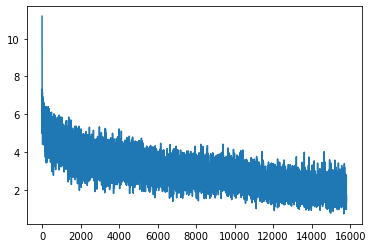

In [ ]:
plt.plot(history)

In [ ]:
m.evaluate(tk_val.select(range(0, 30)), 
           batch_size=16,
           repetition_penalty=3.,
           min_length=1,
           no_repeat_ngram_size=3,
           early_stopping=True,
           num_beams=6)


2it [00:57, 28.89s/it]

0.044643069348951694


In [ ]:
ds = tk_val
f1_buffer = []
for sample in tqdm(ds.iter(batch_size=64)):
  actual_bsize = len(sample['input_ids'])
  out = m.generate(input_ids=tf.reshape(tf.convert_to_tensor(sample['input_ids']), 
                   (actual_bsize, m.input_len)),
                    batch_size=actual_bsize,
                    repetition_penalty=4.,
                    min_length=1,
                    no_repeat_ngram_size=5,
                    early_stopping=True,
                    top_k=10,
                    length_penalty=1.5,
                   num_beams=4,
                    eos_token_id=m.tokenizer.eos_token_id,
                    pad_token_id=m.tokenizer.pad_token_id,
                    )
  generated = m.tokenizer.batch_decode(out, skip_special_tokens=True)
  preprocessed = [[m.tokenizer.pad_token_id if token == -100 else token for token in output] for output in sample['labels']]
  true = m.tokenizer.batch_decode(preprocessed, skip_special_tokens=True)
  for i, sentence in enumerate(generated):
    # print(true[i] + ' | ' + sentence + ' | ' + str(out[i]))
    # print()       
    f1_buffer.append(squad.compute_f1(sentence, true[i]))
print(np.mean(f1_buffer))

336it [3:33:55, 38.20s/it]

0.10238357474046454


In [ ]:
m.model.save_pretrained('/content/drive/MyDrive')

## Question answering - seq2seq approach

Trainer, Encoder and Decoder classes are based on [this implementation](https://gitlab.com/nlp-unibo/nlp-unibo-material/-/blob/master/2022-2023/Assignment%202/tf_seq2seq_bert.py) with little to no tweaks.

In [16]:
from transformers import TFAutoModel
!pip install tensorflow_addons
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(True)


class Seq2SeqBertTrainer(object):

    def __init__(self, encoder, decoder, max_length, out_tokenizer):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)
        self.out_tokenizer = out_tokenizer

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'attention_mask': inputs['encoder_attention_mask']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            self.decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(self.decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })

        start_tokens = tf.fill([batch_size], self.out_tokenizer.word_index['<start>'])
        end_token = self.out_tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return self.out_tokenizer.sequences_to_texts(generated.sample_id.numpy())




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
class Encoder(tf.keras.Model):

    def __init__(self, model_name, decoder_units):
        super(Encoder, self).__init__()
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.reducer = tf.keras.layers.Dense(decoder_units)

    def call(self, inputs, training=False, **kwargs):
        model_output = self.model(inputs)
        all_outputs = model_output[0]
        pooled_output = model_output[1]
        pooled_output = self.reducer(pooled_output)
        return all_outputs, pooled_output, pooled_output


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length-1])
        return decoder_output


The first thing to do is to add the ```<start>``` and ```<end>``` tokens to the answers in the train and validation sets.



In [18]:
def add_start_end_pad(val):
  return {'answer': '<start> ' + val['answer'] + ' <end>'}

ds_train = ds_train.map(add_start_end_pad)
ds_val = ds_val.map(add_start_end_pad)
ds_train.select(range(0, 5))['answer']

  0%|          | 0/85824 [00:00<?, ?ex/s]

  0%|          | 0/21452 [00:00<?, ?ex/s]

['<start> It was formally established in 1475 <end>',
 '<start> research <end>',
 '<start> history, and law <end>',
 '<start> philosophy, science and theology <end>',
 '<start> a  project <end>']

Next we'll create the tokenizer that will be fit on the answers and we'll save its vocabulary size.

In [19]:
out_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
out_tokenizer.fit_on_texts(ds_train['answer'] + ds_val['answer'])
vsize = len(out_tokenizer.word_index) + 1
print(vsize)

44385


We are now ready to create the encoder and decoder. Both of them will have 128 units and the decoder will work with an embedding size of 200. The chosen batch size is 8 for memory reasons.

In [20]:
bsize = 8
encoder = Encoder('distilroberta-base', 128)
decoder = Decoder(vsize, out_len, 200, 128, bsize)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


At this point our samples are still encoded by strings. The next step is to create a function that, for each sample:
- Takes the question and its context and tokenizes them in a single vector of the form ```<start> QUESTION_TOKENIZATION <sep> CONTEXT_TOKENIZATION <end>```. This tokenization will be carried on by the bert tokenizer.
- Takes the answer and tokenizes it in a single vector. This tokenization will be carried on by the ```out_tokenizer```
- Remaps the ```span_start``` and ```span_end``` fields to be token based instead of character based. These fields encode where the answer is located in the context by its start character and ending character; but they lose their meaning if the answer is expressed in tokens instead of strings. The second part of the function carries on this remap, if the part of the context that contains the question got truncated, one or both fields will be set to ```None```.

We developed this function to work on batches of data to take advantage of the paralleling processing offered by the Huggingface datasets.

In [21]:
def tokenize_and_remap_s2s(val, in_tokenizer, out_tokenizer, input_len, out_len):
  # Tokenizing input and output
  input = in_tokenizer(val['question'], val['story'], 
                          max_length=input_len, truncation='only_second', 
                          padding='max_length', 
                          return_offsets_mapping=True)
  tokenized = out_tokenizer.texts_to_sequences(val['answer'])
  out = tf.keras.preprocessing.sequence.pad_sequences(tokenized,
                                                      padding='post',
                                                      maxlen=out_len)
  # Remapping span start and end
  start_pos = []
  end_pos = []
  for i in range(len(val['question'])):
    start = None
    end = None
    it = 0
    while it < len(input['input_ids'][i]):
      if input.sequence_ids(i)[it] == 1:
        if input['offset_mapping'][i][it][0] >= val['span_start'][i] and start is None:
          start = it
        if input['offset_mapping'][i][it][1] > val['span_end'][i] and end is None:
          end = it
      it += 1
    start_pos.append(start)
    end_pos.append(end)
    
  return {'input_ids': input['input_ids'], 
          'input_attention_mask': input['attention_mask'],
          'labels': out,
          'start_positions': start_pos, 
          'end_positions': end_pos}

```prepare_dataset``` wraps the previous function. If specified, this function will delete all the unanswerable questions (the ones with span_start or span_end set to None). We decided to remove this samples from the training set but we will keep the unanswerable question in the training and validation sets. The idea is that these two sets should test our model performances "in the real world", and in the real world it may happen that some questions have a context that is too long for our model to handle so it seems wrong to delete these samples from the evaluation sets.

In [22]:
def prepare_dataset(ds, in_tokenizer, input_len, out_len, out_tokenizer, delete_unans=False):
  print('Tokenizing...\n')
  ds = ds.map(lambda x: tokenize_and_remap_s2s(x, in_tokenizer, out_tokenizer, input_len, out_len), 
             batched=True, 
             num_proc=4, 
             remove_columns=ds_val.column_names)
  if delete_unans:
    start_len = len(ds)
    print('\nRemoving unanswerable questions...\n')
    ds = ds.filter(lambda x: False if x['start_positions'] is None or x['end_positions'] is None else x['start_positions'] < x['end_positions'],
                   num_proc=4)
    print(f'\nRemoved {start_len-len(ds)} rows. ({((start_len-len(ds))/start_len)*100}% of the dataset.)')
  return ds

In [23]:
input_tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
tk_train = prepare_dataset(ds_train, input_tokenizer, input_len, out_len, out_tokenizer, delete_unans=True)
tk_val = prepare_dataset(ds_val, input_tokenizer, input_len, out_len, out_tokenizer)

Tokenizing...

     

#0:   0%|          | 0/22 [00:00<?, ?ba/s]

#1:   0%|          | 0/22 [00:00<?, ?ba/s]

#2:   0%|          | 0/22 [00:00<?, ?ba/s]

#3:   0%|          | 0/22 [00:00<?, ?ba/s]


Removing unanswerable questions...

     

#0:   0%|          | 0/22 [00:00<?, ?ba/s]

#1:   0%|          | 0/22 [00:00<?, ?ba/s]

#2:   0%|          | 0/22 [00:00<?, ?ba/s]

#3:   0%|          | 0/22 [00:00<?, ?ba/s]


Removed 3327 rows. (3.8765380313199107% of the dataset.)
Tokenizing...

     

#0:   0%|          | 0/6 [00:00<?, ?ba/s]

#1:   0%|          | 0/6 [00:00<?, ?ba/s]

#2:   0%|          | 0/6 [00:00<?, ?ba/s]

#3:   0%|          | 0/6 [00:00<?, ?ba/s]

In [24]:
print(tk_train[0]['input_ids'])
print(tk_train[0]['labels'])

[0, 1779, 21, 5, 468, 415, 8207, 1357, 116, 2, 2, 133, 11484, 40201, 12589, 5672, 49038, 55, 10266, 373, 5, 11484, 5672, 50, 1622, 5, 468, 415, 6, 16, 5, 5560, 9, 5, 8427, 4250, 6, 2034, 11, 11484, 412, 4, 8575, 2368, 2885, 11, 501, 2545, 6, 1712, 24, 16, 203, 2530, 6, 24, 16, 65, 9, 5, 7763, 18146, 11, 5, 232, 8, 6308, 65, 9, 5, 144, 1233, 12245, 9, 4566, 14301, 4, 85, 34, 3337, 6, 151, 20993, 6355, 31, 1328, 750, 6, 25, 157, 25, 112, 4, 134, 153, 11118, 2799, 6, 61, 680, 103, 290, 6, 1497, 5853, 879, 873, 5571, 4, 1437, 50118, 50118, 133, 11484, 5672, 16, 10, 557, 5560, 13, 750, 6, 488, 6, 10561, 6, 2866, 8, 37007, 4, 20, 11484, 5672, 16, 490, 7, 1268, 54, 64, 3780, 49, 18952, 8, 557, 782, 4, 23769, 1975, 1517, 918, 13, 940, 892, 9, 6052, 31, 2799, 1027, 227, 504, 2663, 8, 4525, 64, 28, 5372, 11, 621, 50, 30, 7107, 4, 1437, 50118, 50118, 1121, 494, 777, 6, 5, 11484, 5672, 880, 41, 2557, 237, 12, 180, 695, 9, 16808, 3009, 63, 2783, 9, 42486, 6, 7, 28, 156, 577, 804, 4, 1437, 50118, 50

It's now time to create the trainer

In [25]:
trainer = Seq2SeqBertTrainer(encoder, decoder, out_len, out_tokenizer)

We will now fine tune the model for three epochs, this process takes awhile.

10312it [1:30:54,  1.89it/s]


Finished epoch 0, loss 2.3811252117156982


10312it [1:28:53,  1.93it/s]


Finished epoch 1, loss 2.100656509399414


10312it [1:28:41,  1.94it/s]


Finished epoch 2, loss 1.930786371231079


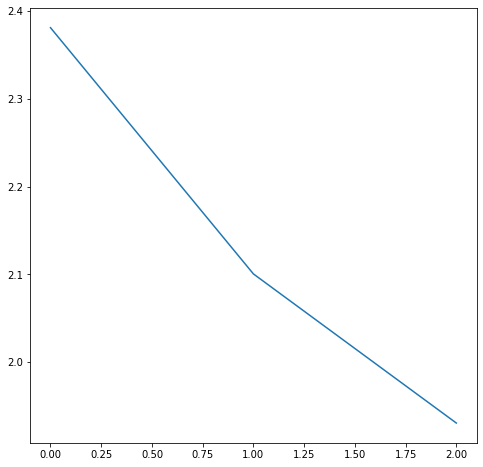

In [40]:
losses=[]
for e in range(3):
  epoch_loss=[]
  for batch in tqdm(tk_train.iter(batch_size=bsize, drop_last_batch=True)):
    actual_bsize = len(batch['input_ids'])
    vals = {'encoder_input_ids': tf.reshape(tf.convert_to_tensor(batch['input_ids'], tf.int32), (bsize, input_len)),
            'encoder_attention_mask': tf.reshape(tf.convert_to_tensor(batch['input_attention_mask'], tf.int32), (bsize, input_len)),
            'decoder_target': tf.reshape(tf.convert_to_tensor(batch['labels'], tf.int32), (bsize, out_len))}
    loss = trainer.batch_fit(vals)
    epoch_loss.append(loss)
  print(f'Finished epoch {e}, loss {np.mean(epoch_loss)}')
  losses.append(np.mean(epoch_loss))
plt.plot(losses)

In [41]:
for j in range(0, 10):
  test = tk_train[j]['input_ids']
  test = tf.reshape(tf.convert_to_tensor(test), (1, input_len))
  ans = trainer.generate(test)
  print(f'Example {j}\nCorrect answer: {out_tokenizer.sequences_to_texts([tk_train[j]["labels"]])}\nPredicted: {trainer.translate(ans)}\n')

Example 0
Correct answer: ['<start> it was formally established in 1475 <end> <UNK> <UNK>']
Predicted: ['no <end>']

Example 1
Correct answer: ['<start> research <end> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 2
Correct answer: ['<start> history, and law <end> <UNK> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 3
Correct answer: ['<start> philosophy, science and theology <end> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 4
Correct answer: ['<start> a project <end> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 5
Correct answer: ['<start> into periods <end> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 6
Correct answer: ['<start> five <end> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 7
Correct answer: ['<start> the vatican apostolic library <end> <UNK> <UNK> <UNK> <UNK>']
Predicted: ['no <end>']

Example 8
Correct answer: ['<start> in vatican ci